# PyTorch Training Pipeline (Fully-Connected Network on MNIST)

This Colab notebook demonstrates the standard end-to-end pipeline to train a neural network in **PyTorch**:
1. Imports + reproducibility
2. Data transforms + dataset + dataloaders
3. Model definition (fully-connected MLP)
4. Loss, optimizer, and (optional) scheduler
5. Training loop + evaluation loop
6. Metrics/plots + saving/loading a checkpoint

**Last updated:** 2026-02-10

## 0) Install / import (Colab usually has PyTorch already)

If your Colab runtime is fresh, the imports below should work directly.

In [1]:

import math
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Better plots in notebooks
%matplotlib inline

## 1) Reproducibility (seeds + deterministic options)

Determinism can be slower, but it is helpful for grading and debugging.

In [2]:

SEED = 0

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Deterministic behavior (may reduce performance)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.benchmark = False

# Choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## 2) Data: transforms, datasets, dataloaders

MNIST images are 28×28 grayscale.
We'll convert to tensors and normalize to roughly mean=0 and std=1.

In [3]:

# MNIST stats commonly used in examples
MNIST_MEAN = 0.1307
MNIST_STD  = 0.3081

transform = transforms.Compose([
    transforms.ToTensor(),                        # -> float32 tensor in [0,1], shape (1,28,28)
    transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

BATCH_SIZE = 128

# For determinism, set num_workers=0 in Colab. (More workers can introduce nondeterminism.)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

len(train_ds), len(test_ds), next(iter(train_loader))[0].shape

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


(60000, 10000, torch.Size([128, 1, 28, 28]))

### Visualize a small batch

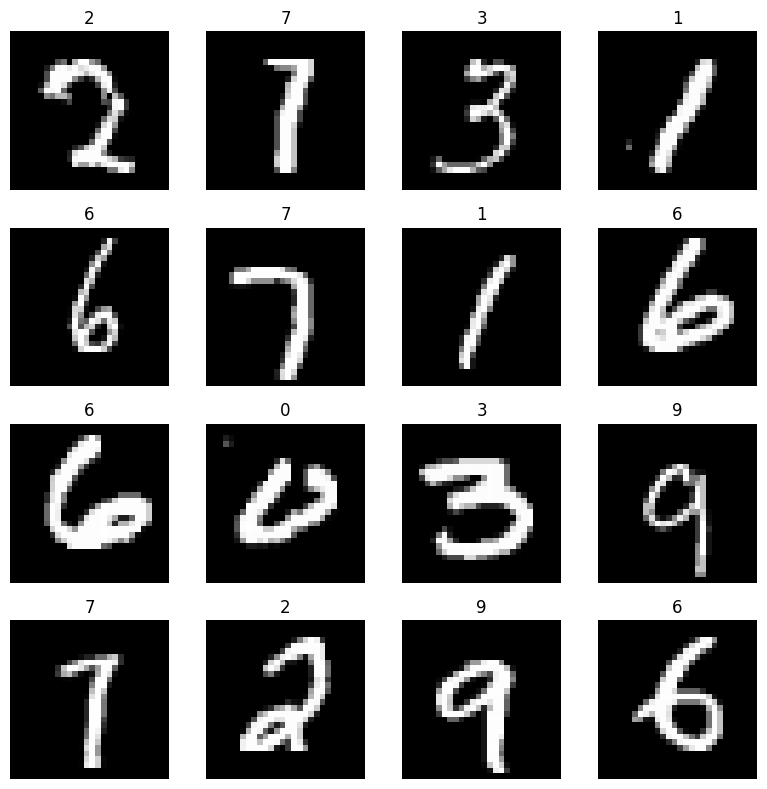

In [4]:

def show_images(images, labels, n=16):
    # images: (B,1,28,28)
    images = images[:n].cpu()
    labels = labels[:n].cpu()

    cols = int(math.sqrt(n))
    rows = math.ceil(n / cols)

    plt.figure(figsize=(cols*2, rows*2))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        # Unnormalize for display
        img = images[i] * MNIST_STD + MNIST_MEAN
        plt.imshow(img.squeeze(0), cmap="gray")
        plt.title(int(labels[i]))
        plt.axis("off")
    plt.tight_layout()
    plt.show()

xb, yb = next(iter(train_loader))
show_images(xb, yb, n=16)

## 3) Model: fully-connected network (MLP)

A fully-connected network expects a vector input, so we **flatten** 28×28 to 784.

In [5]:

class MLP(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=256, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),                        # (N,1,28,28) -> (N,784)
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes),  # logits (no softmax here)
        )

    def forward(self, x):
        return self.net(x)

model = MLP().to(device)
model

MLP(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=10, bias=True)
  )
)

## 4) Loss + optimizer (+ optional scheduler)

For multi-class classification with integer labels, use **CrossEntropyLoss**.
It expects **logits** (raw scores) and applies log-softmax internally.

In [6]:

criterion = nn.CrossEntropyLoss()

lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Optional: learning-rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

## 5) Training and evaluation loops

- `train_one_epoch`: model.train(), backprop, optimizer.step()
- `evaluate`: model.eval(), no_grad(), compute loss/accuracy

In [7]:

def accuracy_from_logits(logits, y):
    # logits: (N,10), y: (N,)
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    n_batches = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc  += accuracy_from_logits(logits, y)
        n_batches += 1

    return running_loss / n_batches, running_acc / n_batches

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    n_batches = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        loss = criterion(logits, y)

        running_loss += loss.item()
        running_acc  += accuracy_from_logits(logits, y)
        n_batches += 1

    return running_loss / n_batches, running_acc / n_batches

## 6) Train the model

In [8]:

EPOCHS = 8

history = {
    "train_loss": [],
    "train_acc":  [],
    "test_loss":  [],
    "test_acc":   [],
    "lr":         [],
}

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc   = evaluate(model, test_loader, criterion, device)

    # track lr (useful when schedulers are active)
    current_lr = optimizer.param_groups[0]["lr"]
    history["lr"].append(current_lr)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["test_loss"].append(test_loss)
    history["test_acc"].append(test_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"lr={current_lr:.2e} | "
          f"train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
          f"test:  loss={test_loss:.4f}, acc={test_acc:.4f}")

    scheduler.step()

Epoch 01/8 | lr=1.00e-03 | train: loss=0.2560, acc=0.9234 | test:  loss=0.1292, acc=0.9571
Epoch 02/8 | lr=1.00e-03 | train: loss=0.0944, acc=0.9706 | test:  loss=0.0867, acc=0.9731
Epoch 03/8 | lr=1.00e-03 | train: loss=0.0653, acc=0.9786 | test:  loss=0.0710, acc=0.9766
Epoch 04/8 | lr=5.00e-04 | train: loss=0.0332, acc=0.9901 | test:  loss=0.0632, acc=0.9804
Epoch 05/8 | lr=5.00e-04 | train: loss=0.0232, acc=0.9931 | test:  loss=0.0652, acc=0.9812
Epoch 06/8 | lr=5.00e-04 | train: loss=0.0202, acc=0.9939 | test:  loss=0.0605, acc=0.9815
Epoch 07/8 | lr=2.50e-04 | train: loss=0.0095, acc=0.9976 | test:  loss=0.0582, acc=0.9828
Epoch 08/8 | lr=2.50e-04 | train: loss=0.0064, acc=0.9987 | test:  loss=0.0586, acc=0.9830


### Plot training curves

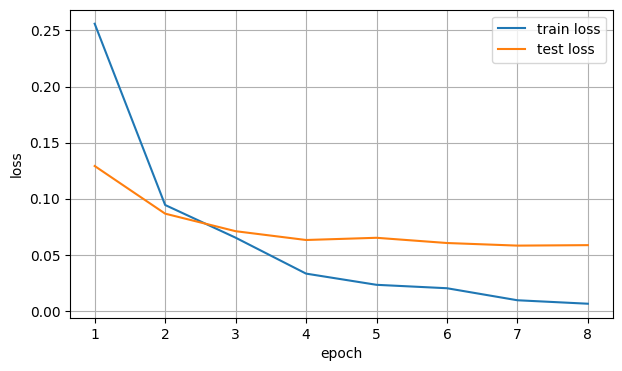

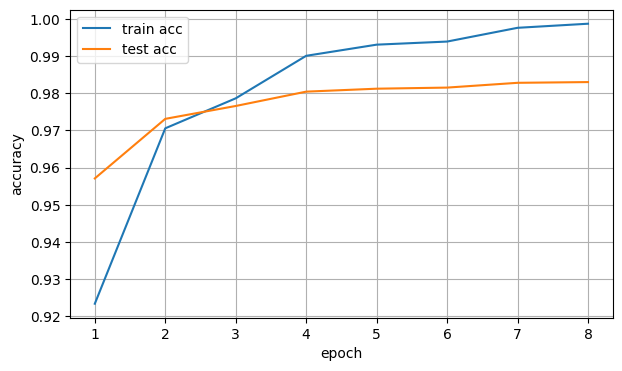

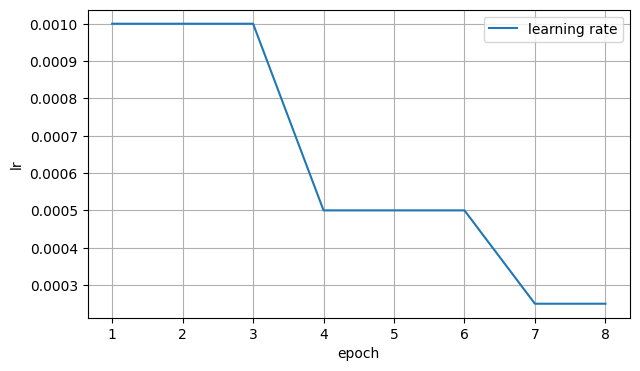

In [9]:

epochs = np.arange(1, EPOCHS + 1)

plt.figure(figsize=(7,4))
plt.plot(epochs, history["train_loss"], label="train loss")
plt.plot(epochs, history["test_loss"],  label="test loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(epochs, history["train_acc"], label="train acc")
plt.plot(epochs, history["test_acc"],  label="test acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(epochs, history["lr"], label="learning rate")
plt.xlabel("epoch")
plt.ylabel("lr")
plt.legend()
plt.grid(True)
plt.show()

## 7) Inspect predictions (qualitative check)

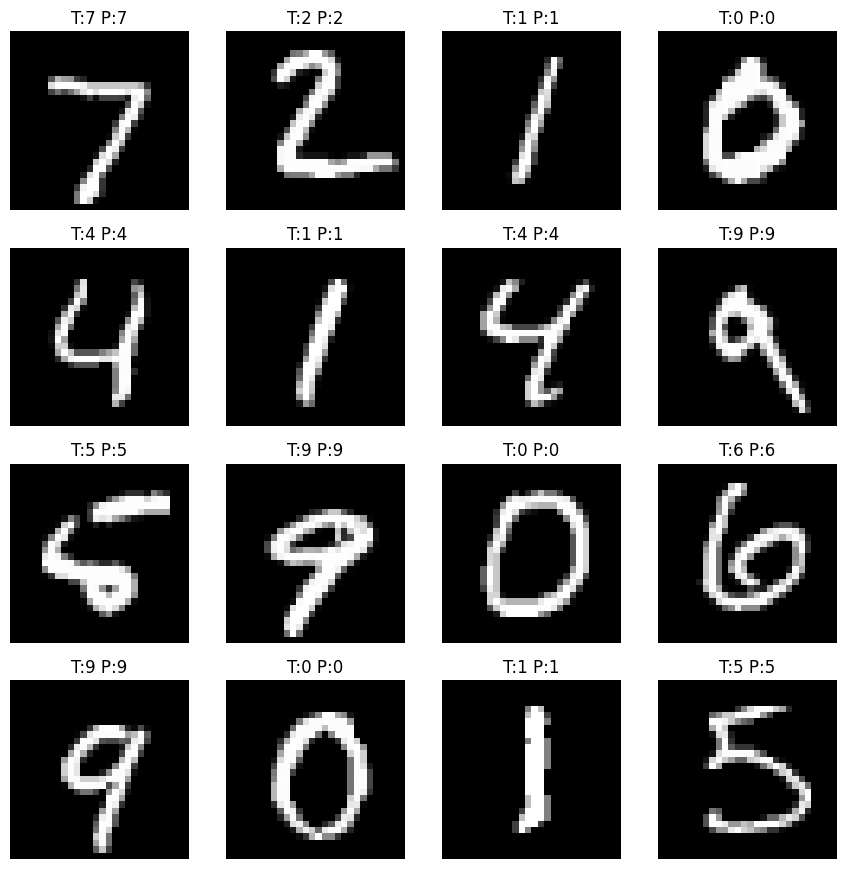

In [10]:

@torch.no_grad()
def show_predictions(model, loader, n=16):
    model.eval()
    x, y = next(iter(loader))
    x = x.to(device)
    y = y.to(device)

    logits = model(x)
    preds = logits.argmax(dim=1)

    # show images with (true, pred)
    x_cpu = x[:n].cpu()
    y_cpu = y[:n].cpu()
    p_cpu = preds[:n].cpu()

    cols = int(math.sqrt(n))
    rows = math.ceil(n / cols)

    plt.figure(figsize=(cols*2.2, rows*2.2))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        img = x_cpu[i] * MNIST_STD + MNIST_MEAN
        plt.imshow(img.squeeze(0), cmap="gray")
        plt.title(f"T:{int(y_cpu[i])} P:{int(p_cpu[i])}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_predictions(model, test_loader, n=16)

## 8) Save / load checkpoint

This is the typical pattern for saving a trained model and optimizer state.

In [11]:

ckpt_path = "mlp_mnist_checkpoint.pt"

torch.save({
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "history": history,
    "seed": SEED,
}, ckpt_path)

print("Saved:", ckpt_path)

Saved: mlp_mnist_checkpoint.pt


In [12]:

# Example load into a fresh model
loaded = torch.load(ckpt_path, map_location=device)

model2 = MLP().to(device)
model2.load_state_dict(loaded["model_state"])

optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3)
optimizer2.load_state_dict(loaded["optimizer_state"])

test_loss2, test_acc2 = evaluate(model2, test_loader, criterion, device)
print(f"Reloaded model | test loss={test_loss2:.4f}, test acc={test_acc2:.4f}")

Reloaded model | test loss=0.0586, test acc=0.9830
